In [1]:
# https://github.com/srikeshnagoji/unet3p-attn/tree/unet-3p-with-attention-rearch-v2

In [2]:
# # DO 

# !pip uninstall Albumentations
# !pip install Albumentations==0.5.2

In [3]:
# Dice link: https://towardsdatascience.com/how-accurate-is-image-segmentation-dd448f896388

In [4]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
import numpy as np
import seaborn as sns

from tqdm.notebook import tqdm
import time
import random

plt.style.use("dark_background")
%matplotlib inline


In [5]:
from prepareData.prepareData import get_dataset_dataframe
from util.helper import pos_neg_diagnosis, show_aug, train_model, plot_model_history, viz_pred_output
from prepareData import augmentData, customDatasetObject
from model.unet3p_attention import UNet_3Plus_attn
from model.unet3p import UNet3Plus
from model.unet_attention import AttentionUNet
from metrics.diceMetrics import dice_coef_metric, DiceLoss, compute_iou


In [6]:
BASE_PATH= "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m"

In [7]:
BASE_LEN = len(BASE_PATH) + len("/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_")
END_LEN = len(".tif")
END_MASK_LEN = len("_mask.tif")

IMG_SIZE = 512

# Prepare data

In [8]:
df = get_dataset_dataframe(BASE_PATH)

[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/data.csv
[INFO] This is not a dir --> /Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/README.md


In [9]:
df

,dir_name,image_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...
...,...,...
7853,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7854,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7855,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...
7856,TCGA_FG_A60K_20040224,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [10]:
df_imgs = df[~df["image_path"].str.contains("mask")]
df_masks = df[df["image_path"].str.contains("mask")]

In [11]:
df_imgs.iloc[0,1][BASE_LEN: -END_LEN]

'9'

In [12]:
imgs = sorted(df_imgs["image_path"].values, key= lambda x: int((x[BASE_LEN: -END_LEN])))
masks = sorted(df_masks["image_path"].values, key=lambda x: int((x[BASE_LEN: -END_MASK_LEN])))

In [13]:
# sanity check
idx = random.randint(0, len(imgs)-1)
print(f"This image *{imgs[idx]}*\n Belongs to the mask *{masks[idx]}*")

This image */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10.tif*
 Belongs to the mask */Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_HT_7602_19951103/TCGA_HT_7602_19951103_10_mask.tif*


In [14]:
# final dataframe
dff = pd.DataFrame({"patient": df_imgs.dir_name.values,
                   "image_path": imgs,
                   "mask_path": masks})

dff.head()

,patient,image_path,mask_path
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...


In [15]:
dff.iloc[0,1]

'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1.tif'

In [16]:
dff.iloc[0,2]


'/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/kaggle_3m/TCGA_CS_6667_20011105/TCGA_CS_6667_20011105_1_mask.tif'

In [17]:
dff["diagnosis"] = dff["mask_path"].apply(lambda x: pos_neg_diagnosis(x))

dff.head()

,patient,image_path,mask_path,diagnosis
0,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
1,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
2,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
3,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0
4,TCGA_CS_6667_20011105,/Users/srikeshnagoji/Documents/PythonWorkSpace...,/Users/srikeshnagoji/Documents/PythonWorkSpace...,0


In [18]:
dff.shape


(3929, 4)

In [19]:
dff.diagnosis.value_counts()

0    2556
1    1373
Name: diagnosis, dtype: int64

In [20]:
print("Amount of patients: ", len(set(dff.patient)))
print("Amount of records: ", len(dff))

Amount of patients:  110
Amount of records:  3929


# Data Augmentation

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

from sklearn.model_selection import train_test_split

In [22]:
import platform
import sklearn as sk
import sys
has_gpu = torch.cuda.is_available()
has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

print(f"Python Platform: {platform.platform()}")
print(f"PyTorch Version: {torch.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if has_gpu else "NOT AVAILABLE")
print("MPS (Apple Metal) is", "AVAILABLE" if has_mps else "NOT AVAILABLE")
print(f"Target device is {device}")

Python Platform: macOS-13.0.1-arm64-arm-64bit
PyTorch Version: 1.12.1

Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]
Pandas 1.5.1
Scikit-Learn 1.1.3
GPU is NOT AVAILABLE
MPS (Apple Metal) is AVAILABLE
Target device is mps


# Split Data and DataLoaders

In [23]:
train_df, val_df = train_test_split(dff, stratify=dff.diagnosis, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.diagnosis, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (3111, 4) 
Val: (393, 4) 
Test: (425, 4)


In [24]:
train_dataset = customDatasetObject.BrainMRIDataset(train_df, transform=augmentData.transform)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)

val_dataset = customDatasetObject.BrainMRIDataset(val_df, transform=augmentData.transform)
val_dataloader = DataLoader(val_dataset, batch_size=10,  shuffle=True)

test_dataset = customDatasetObject.BrainMRIDataset(test_df, transform=augmentData.transform)
test_dataloader = DataLoader(test_dataset, batch_size=10,shuffle=True)

In [25]:
len(train_dataset)

3111

In [26]:
len(val_dataset)

393

In [27]:
len(test_dataset)

425

torch.Size([10, 3, 128, 128]) torch.Size([10, 1, 128, 128])


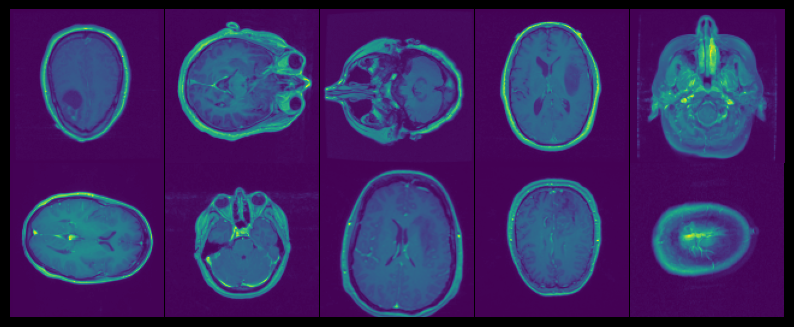

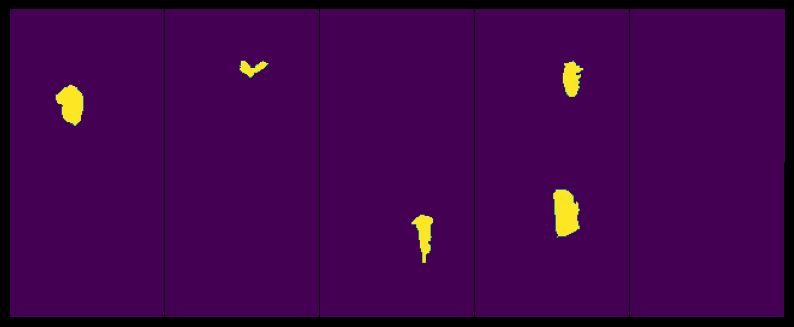

In [28]:
images, masks = next(iter(train_dataloader))
print(images.shape, masks.shape)

show_aug(images)
show_aug(masks, norm=False)

In [29]:
# check sanity
output = torch.randn(1,3,256,256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

In [30]:
# sanity check
DiceLoss()(F.sigmoid(torch.tensor([0.7, 1., 1.])), 
              torch.tensor([1.,1.,1.]))

/Users/srikeshnagoji/miniforge3/envs/capstone/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor(0.1419)

# U-NET 3+ with attention

In [31]:

unet3p_attn = UNet_3Plus_attn(n_classes=1).to(device)

In [32]:
# Training

In [33]:
# PATH = "model_unet_3p_attn.pt"



In [34]:
opt_unet_3p_attn = torch.optim.Adamax(unet3p_attn.parameters(), lr=1e-4)


In [35]:
# ckp_path = "path/to/checkpoint/checkpoint.pt"


In [36]:
# %%time
num_ep = 1
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, num_ep, device=device)

total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

Epoch [0]
Mean loss on train: 0.522686481093749 
Mean DICE on train: 0.5145241458914652 
Mean DICE on validation: 0.6063069126861612


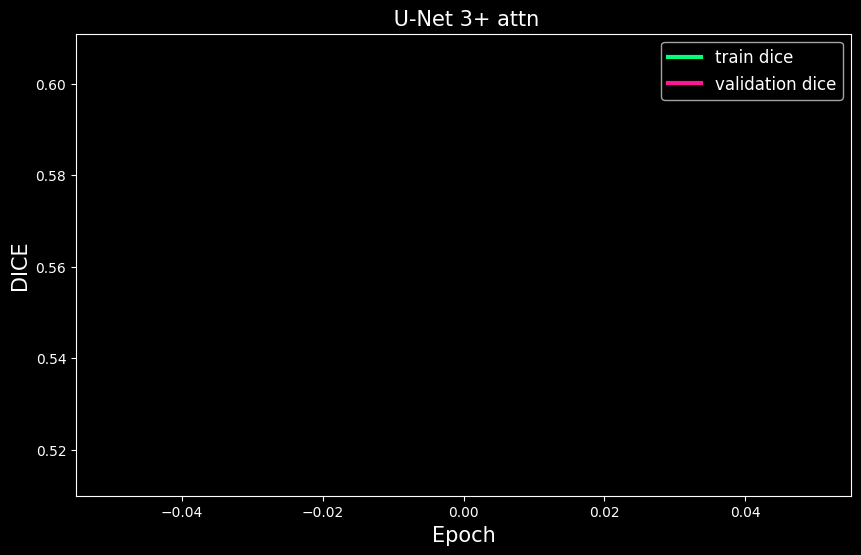

In [37]:
plot_model_history(" U-Net 3+ attn", aun_th, aun_vh, num_ep)

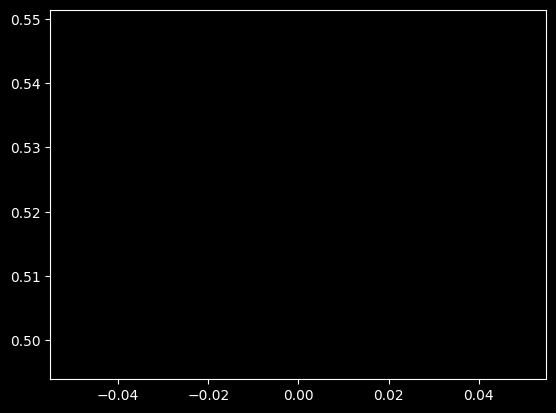

In [38]:
plt.plot(range(num_ep), aun_lh)

In [40]:
test_iou = compute_iou(unet3p_attn, test_dataloader, device)
print(f"""U-Net 3+ Attention\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

U-Net 3+ Attention
Mean IoU of the test images - 64.0%


In [ ]:
ckp_path = "/Users/srikeshnagoji/Documents/PythonWorkSpace/jupyter_lab_workspace/PES/CAPSTONE/v3_pytorch_refactored/checkpoints/checkpoint.pt"
aun_lh, aun_th, aun_vh = train_model("UNet_3p_attn", unet3p_attn, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p_attn, False, num_ep, device=device, ckp_path=ckp_path )

total params of UNet_3p_attn model: 28043917
trainable params of UNet_3p_attn model: 28043917
Previously trained model weights state_dict loaded...
Previously trained optimizer state_dict loaded...
Previously trained for 0 number of epochs...
Train for 1 more epochs...
[INFO] Model is initializing... UNet_3p_attn


  0%|          | 0/312 [00:00<?, ?it/s]

# U-Net 3+

In [ ]:
unet3p = UNet3Plus(n_classes=1).to(device)

In [ ]:
# PATH = "model_unet_3p.pt"

In [ ]:
opt_unet_3p = torch.optim.Adamax(unet3p.parameters(), lr=1e-3)

In [ ]:
# %%time
num_ep = 1
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_3p", unet3p, train_dataloader, val_dataloader, DiceLoss(), opt_unet_3p, False, num_ep, device=device)

In [ ]:
plot_model_history("U-Net 3+", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(unet3p, test_dataloader)
print(f"""U-Net 3+\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")


# UNet with Attention

In [ ]:
attention_unet = AttentionUNet(n_classes=1).to(device)

In [ ]:
# PATH = "model_unet_with_attn.pt"

In [ ]:
opt_unet_attn = torch.optim.Adamax(attention_unet.parameters(), lr=1e-3)

In [ ]:
# %%time
num_ep = 1
# try until 30

# aun_lh, aun_th, aun_vh = train_model("Attention UNet", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt, False, num_ep)
aun_lh, aun_th, aun_vh = train_model("UNet_attn", attention_unet, train_dataloader, val_dataloader, DiceLoss(), opt_unet_attn, False, num_ep, device=device)

In [ ]:
plot_model_history("Attention U-Net", aun_th, aun_vh, num_ep)

In [ ]:
plt.plot(range(num_ep), aun_lh)

In [ ]:
test_iou = compute_iou(attention_unet, test_dataloader)
print(f"""Attention U-Net\nMean IoU of the test images - {np.around(test_iou, 2)*100}%""")

In [ ]:
#============================== EXP : viz pred mask

In [ ]:
# a = torch.zeros(4, 5, 6)
# a = a.unsqueeze(0)

# a.shape


In [ ]:
test_dataset.df.head(10)#[test_dataset.df['diagnosis']==1]

In [ ]:
test_dataset.df.loc[1103]

In [ ]:
test_dataset[1][1].sum()

In [ ]:
idx = 33
viz_pred_output(unet3p_attn, test_dataloader, idx, test_dataset, device)

In [ ]:
#==============================